In [60]:
import pandas as pd

def create_df_from_sheet(sheet: str) -> pd.DataFrame:
    df = pd.read_excel("./all data(from manon).xlsx", sheet_name=sheet)
    df.columns = df.iloc[1]
    df = df.iloc[2:]
    if len(df.columns) > 4:
        df.drop(columns=df.columns[-2:], axis=1, inplace=True)
    df.columns = ["timestamp", "no_units", "RangeCAL_uS", "SkinResistanceCAL_kOhms"]
    return df


def plot_df(df: pd.DataFrame):
    df.iloc[:, [0, 1]].plot()
    df.iloc[:, [0, 2]].plot()
    df.iloc[:, [0, 3]].plot()

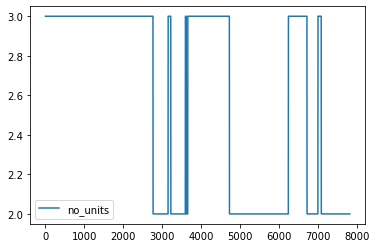

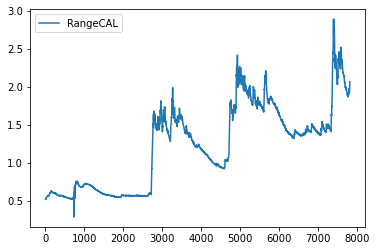

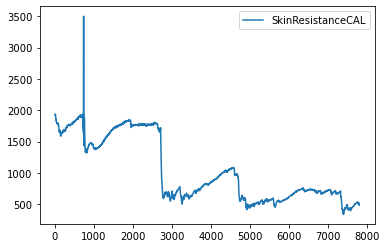

In [47]:
test612_1 = create_df_from_sheet("612_1")
plot_df(test612_1)

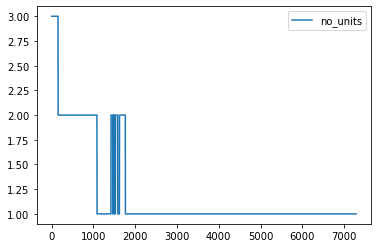

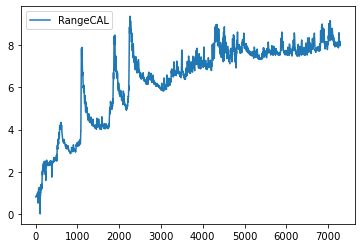

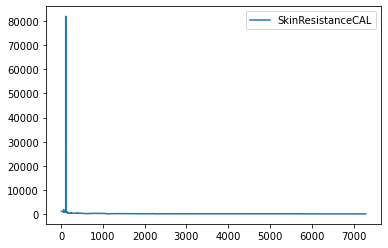

In [48]:
test612_2 = create_df_from_sheet("612_2")
plot_df(test612_2)

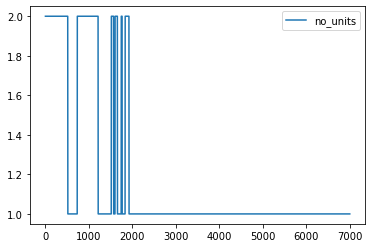

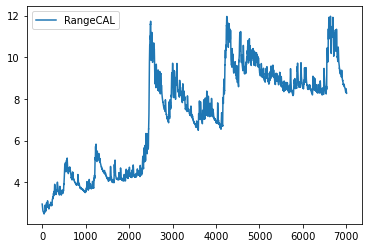

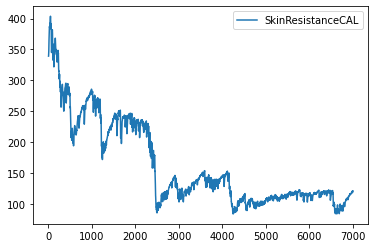

In [49]:
test612_3 = create_df_from_sheet("612_3")
plot_df(test612_3)

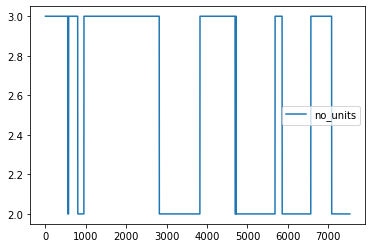

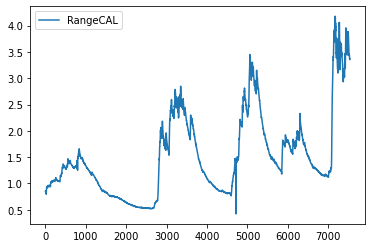

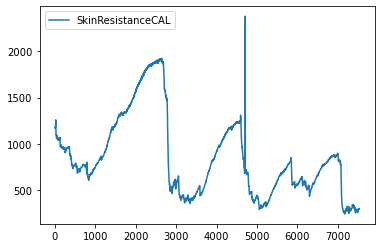

In [50]:
test612_4 = create_df_from_sheet("612_4")
plot_df(test612_4)

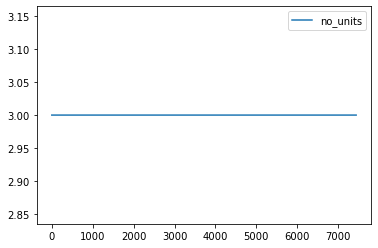

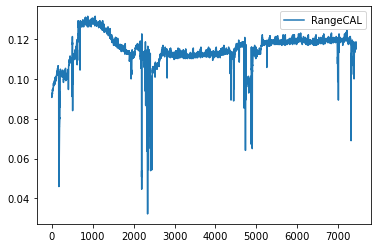

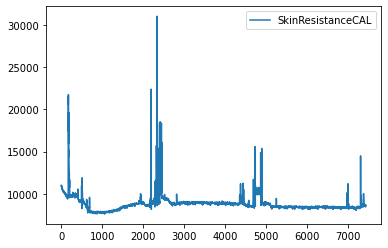

In [51]:
test612_5 = create_df_from_sheet("612_5")
plot_df(test612_5)

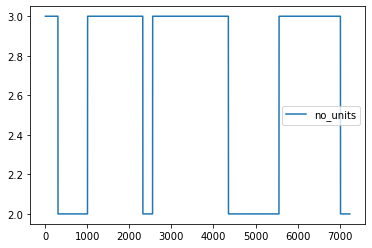

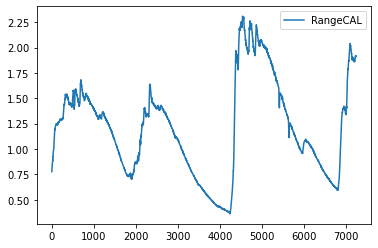

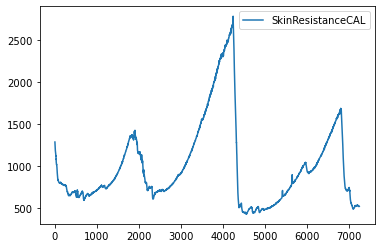

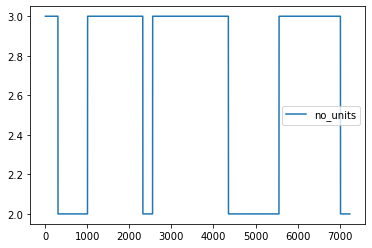

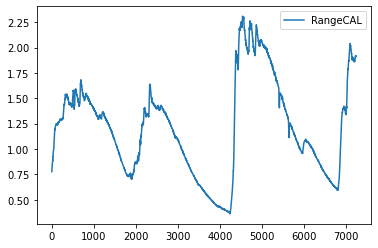

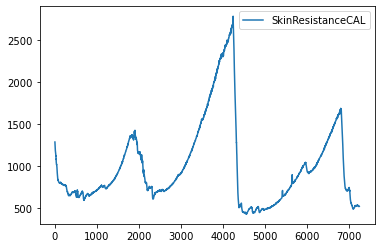

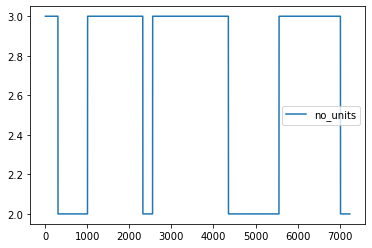

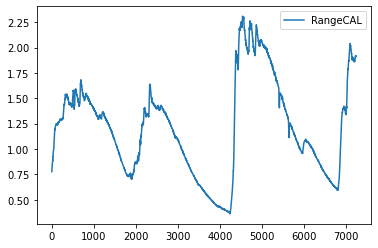

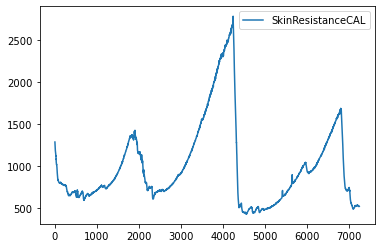

In [57]:
test612_6 = create_df_from_sheet("612_6")
plot_df(test612_6)

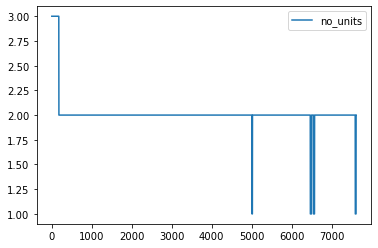

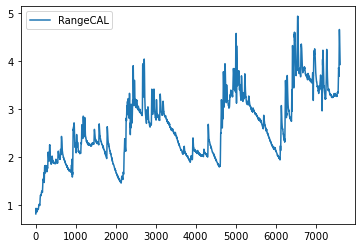

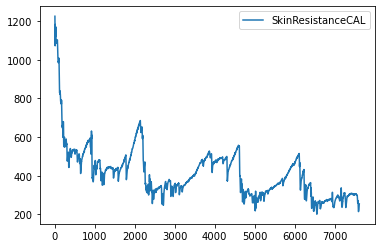

In [58]:
test612_7 = create_df_from_sheet("612_7")
plot_df(test612_7)

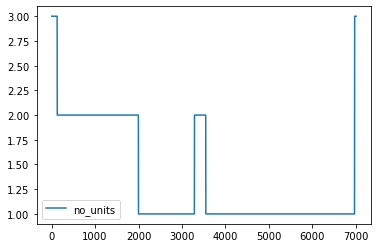

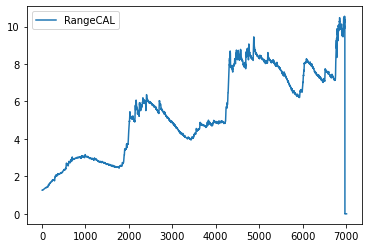

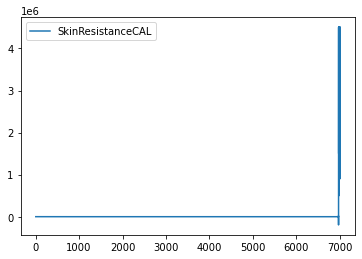

In [59]:
test712_1 = create_df_from_sheet("712_1")
plot_df(test712_1)

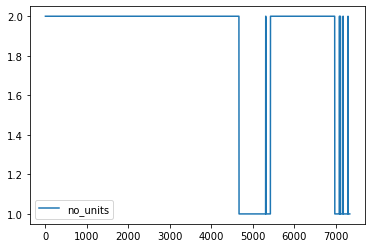

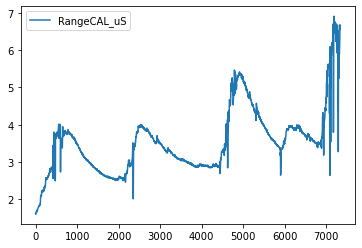

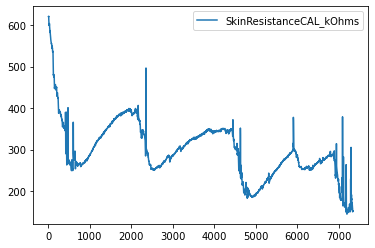

In [61]:
test712_2 = create_df_from_sheet("712_2")
plot_df(test712_2)

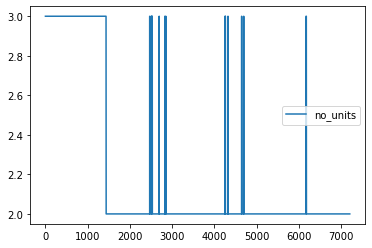

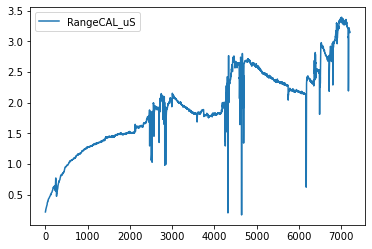

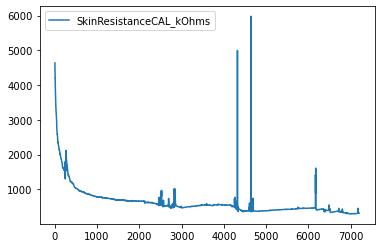

In [62]:
test712_3 = create_df_from_sheet("712_3")
plot_df(test712_3)

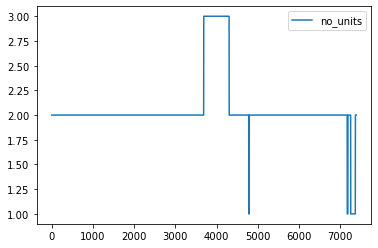

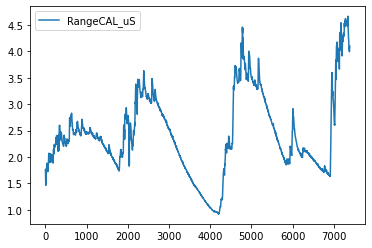

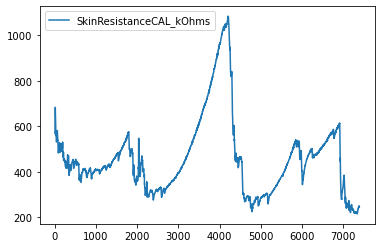

In [63]:
test712_4 = create_df_from_sheet("712_4")
plot_df(test712_4)

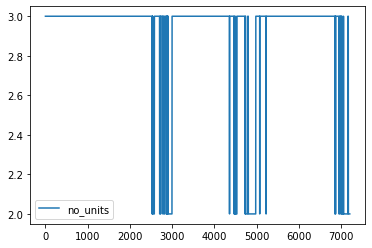

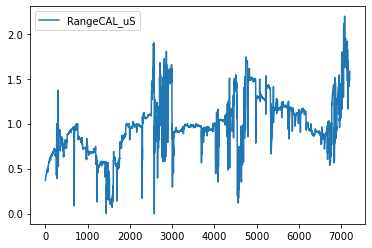

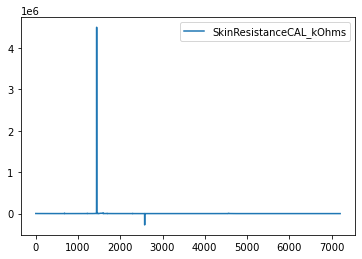

In [64]:
test712_5 = create_df_from_sheet("712_5")
plot_df(test712_5)

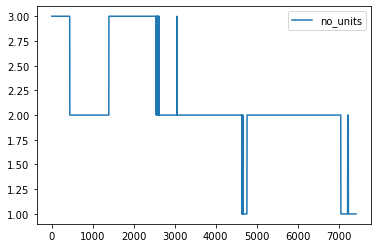

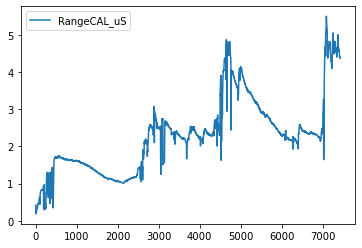

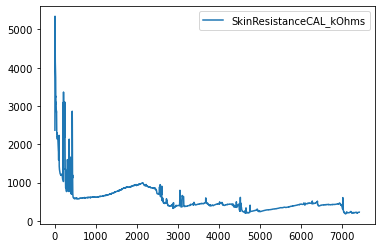

In [65]:
test712_6 = create_df_from_sheet("712_6")
plot_df(test712_6)

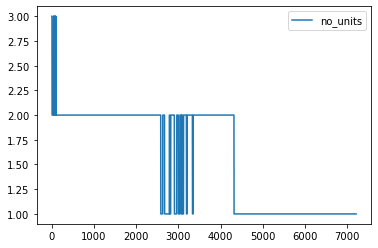

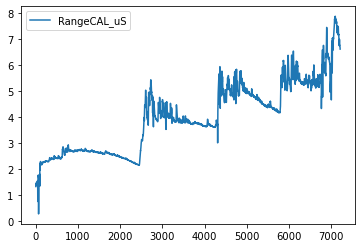

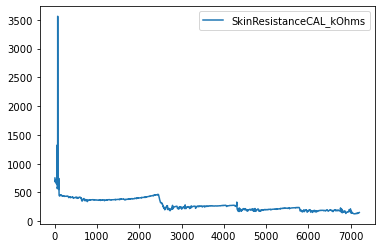

In [66]:
test712_7 = create_df_from_sheet("712_7")
plot_df(test712_7)

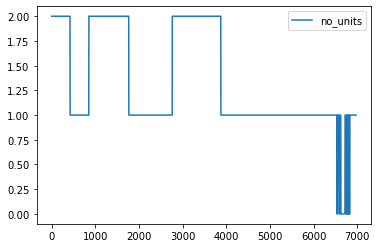

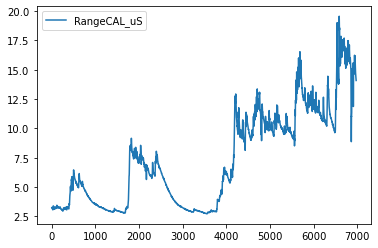

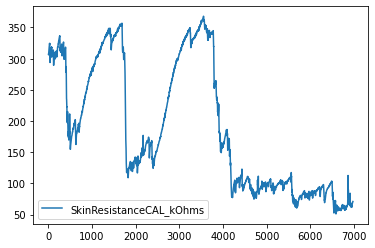

In [67]:
test712_8 = create_df_from_sheet("712_8")
plot_df(test712_8)